In [1]:
from huggingface_hub import login
login(token=os.environ.get("HF_TOKEN"))  # Set HF_TOKEN or use huggingface_hub.login() interactively

In [2]:
!pip install timm xformers

INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 915.7/915.7 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 113.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.1/139.1 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.3/188.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 34.9 MB/s eta 0:00:00
  Attempting uninstall: triton
    Found existing installation: triton 3.5.0
    Uninstalling triton-3.5.0:
      Successfully uninstalled triton-3.5.0
  Attempting uninstall: nvidia-nvshmem-cu12
    Found existing installation: nvidia-nvshmem-cu12 3.3.20
    Uninstalling nvidia-nvshmem-cu12-3.3.20:
      Successfully uninstalled nvidia-nvshmem-cu12-3.3.20
  Attempting 

In [3]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 60.4 MB/s eta 0:00:00


In [4]:
!pip install -U transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 134.8 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 5.0.0
    Uninstalling transformers-5.0.0:
      Successfully uninstalled transformers-5.0.0
^C


In [2]:
import torch
import gc

# Clear any existing models/tensors
gc.collect()
torch.cuda.empty_cache()



In [3]:
"""
DINOv3 Feature Visualization using PCA
Based on: https://github.com/facebookresearch/dinov3/blob/main/notebooks/pca.ipynb

Uses the satellite-pretrained 7B model for better performance on aerial imagery.
"""
import os
import urllib
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from sklearn.decomposition import PCA
from transformers import AutoModel, AutoImageProcessor

# ============ Configuration ============
PATCH_SIZE = 16  # This model uses 16x16 patches (vit7b16 = ViT with 16x16 patches)
IMAGE_SIZE = 1024  # Must be divisible by PATCH_SIZE

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

# Model - satellite pretrained 7B model (best for aerial/road imagery)
MODEL_NAME = "facebook/dinov3-vit7b16-pretrain-sat493m"

# ============ Load Model ============
print(f"Loading model: {MODEL_NAME}")
model = AutoModel.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float16,
    trust_remote_code=True,
)
model.cuda()
model.eval()
print("Model loaded successfully!")

# ============ Image Loading Functions ============
def load_image_from_url(url: str) -> Image.Image:
    """Load image from URL"""
    with urllib.request.urlopen(url) as f:
        return Image.open(f).convert("RGB")

def load_image(path_or_url: str) -> Image.Image:
    """Load image from path or URL"""
    if path_or_url.startswith("http"):
        return load_image_from_url(path_or_url)
    else:
        return Image.open(path_or_url).convert("RGB")

def resize_transform(
    image: Image.Image,
    image_size: int = IMAGE_SIZE,
    patch_size: int = PATCH_SIZE,
) -> torch.Tensor:
    """Resize image to dimensions exactly divisible by patch size"""
    w, h = image.size
    aspect_ratio = w / h

    # Calculate target dimensions that are exactly divisible by patch_size
    if aspect_ratio >= 1:  # Wider than tall
        new_h = (image_size // patch_size) * patch_size
        new_w = (int(new_h * aspect_ratio) // patch_size) * patch_size
    else:  # Taller than wide
        new_w = (image_size // patch_size) * patch_size
        new_h = (int(new_w / aspect_ratio) // patch_size) * patch_size

    # Ensure minimum size
    new_h = max(new_h, patch_size)
    new_w = max(new_w, patch_size)

    return TF.to_tensor(TF.resize(image, (new_h, new_w)))

# ============ Feature Extraction ============
# DINOv3 outputs: 1 CLS token + 4 register tokens + patch tokens
NUM_REGISTER_TOKENS = 4
NUM_PREFIX_TOKENS = 1 + NUM_REGISTER_TOKENS  # CLS + registers = 5

def extract_features(model, image_tensor: torch.Tensor) -> tuple:
    """
    Extract patch features from the HuggingFace DINOv3 model.

    DINOv3 output structure: [CLS, REG1, REG2, REG3, REG4, patch_0, patch_1, ...]
    We skip the first 5 tokens (1 CLS + 4 register tokens) to get only patch tokens.

    Returns:
        features: Tensor of shape [N, D] where N = h_patches * w_patches
        h_patches: Number of patches in height
        w_patches: Number of patches in width
    """
    with torch.inference_mode():
        # Move to GPU with float16
        pixel_values = image_tensor.unsqueeze(0).cuda().half()

        # Get model output
        outputs = model(pixel_values=pixel_values)

        # last_hidden_state shape: [batch, 1 + 4 + num_patches, hidden_dim]
        # = [batch, CLS + 4_registers + patch_tokens, hidden_dim]
        all_tokens = outputs.last_hidden_state

        # Remove batch dimension, CLS token, and 4 register tokens
        # Skip first 5 tokens to get only patch tokens
        features = all_tokens[0, NUM_PREFIX_TOKENS:, :].float().cpu()

        # Calculate grid dimensions from image size
        num_patches = features.shape[0]
        h_img, w_img = image_tensor.shape[1], image_tensor.shape[2]

        # Calculate expected grid based on image dimensions
        h_patches = h_img // PATCH_SIZE
        w_patches = w_img // PATCH_SIZE
        expected_patches = h_patches * w_patches

        print(f"  Image: {w_img}x{h_img}")
        print(f"  Total tokens from model: {all_tokens.shape[1]} (1 CLS + 4 reg + {all_tokens.shape[1] - 5} patches)")
        print(f"  Patch tokens: {num_patches}, Expected: {expected_patches} ({w_patches}x{h_patches})")
        print(f"  Feature dim: {features.shape[1]}")

        # Verify dimensions match
        if num_patches != expected_patches:
            print(f"  WARNING: Patch count mismatch! Model may have cropped the image.")
            # Find the correct factorization
            import math
            aspect_ratio = w_img / h_img
            best_h, best_w = 1, num_patches
            best_diff = float('inf')

            for h in range(1, int(math.sqrt(num_patches)) + 1):
                if num_patches % h == 0:
                    w = num_patches // h
                    diff = abs(w / h - aspect_ratio)
                    if diff < best_diff:
                        best_diff = diff
                        best_h, best_w = h, w

            h_patches, w_patches = best_h, best_w
            print(f"  Adjusted grid to: {w_patches}x{h_patches}")

        print(f"  Final grid: {w_patches}x{h_patches} = {w_patches * h_patches} patches")

    return features, h_patches, w_patches

# ============ PCA Visualization ============
def visualize_pca_features(
    features: torch.Tensor,
    h_patches: int,
    w_patches: int,
    whiten: bool = True,
    scale: float = 1.5,
    use_minmax_norm: bool = False,
) -> torch.Tensor:
    """
    Compute PCA visualization of features.

    Args:
        features: Tensor of shape [N, D] where N = h_patches * w_patches
        h_patches: Number of patches in height
        w_patches: Number of patches in width
        whiten: Use PCA whitening for better color distribution
        scale: Scaling factor before sigmoid (higher = more vibrant colors)
        use_minmax_norm: If True, use min-max normalization instead of sigmoid

    Returns:
        RGB image tensor of shape [3, H, W]
    """
    # Normalize features before PCA (important for stability)
    features_normalized = F.normalize(features, p=2, dim=1)

    # Fit PCA with 3 components (for RGB)
    pca = PCA(n_components=3, whiten=whiten)
    pca.fit(features_normalized.numpy())

    print(f"  PCA explained variance: {pca.explained_variance_ratio_}")
    print(f"  Total variance explained: {sum(pca.explained_variance_ratio_):.2%}")

    # Transform features
    projected = torch.from_numpy(pca.transform(features_normalized.numpy()))

    # Reshape to spatial dimensions
    projected_image = projected.view(h_patches, w_patches, 3)

    if use_minmax_norm:
        # Min-max normalization per channel
        for c in range(3):
            channel = projected_image[:, :, c]
            min_val, max_val = channel.min(), channel.max()
            projected_image[:, :, c] = (channel - min_val) / (max_val - min_val + 1e-8)
    else:
        # Sigmoid with scaling for vibrant colors (DINOv3 style)
        projected_image = torch.sigmoid(projected_image * scale)

    # Rearrange to [C, H, W]
    projected_image = projected_image.permute(2, 0, 1)

    return projected_image


def visualize_pca_features_enhanced(
    features: torch.Tensor,
    h_patches: int,
    w_patches: int,
) -> torch.Tensor:
    """
    Enhanced PCA visualization that better separates semantic regions.
    Uses a combination of techniques for cleaner visualization.
    """
    # L2 normalize features
    features_norm = F.normalize(features, p=2, dim=1)

    # Fit PCA - try without whitening for this approach
    pca = PCA(n_components=3, whiten=False)
    projected = pca.fit_transform(features_norm.numpy())

    print(f"  PCA explained variance: {pca.explained_variance_ratio_}")

    # Convert to tensor and reshape
    projected = torch.from_numpy(projected).float()
    projected_image = projected.view(h_patches, w_patches, 3)

    # Normalize each component to [0, 1] using percentile clipping
    # This reduces the impact of outliers
    for c in range(3):
        channel = projected_image[:, :, c].flatten()
        low = torch.quantile(channel, 0.02)
        high = torch.quantile(channel, 0.98)
        projected_image[:, :, c] = torch.clamp(
            (projected_image[:, :, c] - low) / (high - low + 1e-8),
            0, 1
        )

    # Rearrange to [C, H, W]
    projected_image = projected_image.permute(2, 0, 1)

    return projected_image

# ============ Main Visualization Function ============
def visualize_dino_features(
    image_path_or_url: str,
    image_size: int = IMAGE_SIZE,
    save_path: str = "dino_features_visualization.png",
    dpi: int = 150,
):
    """
    Complete pipeline to visualize DINO features for an image.
    """
    # Load and preprocess image
    print(f"Loading image: {image_path_or_url}")
    image = load_image(image_path_or_url)
    print(f"Original size: {image.size}")

    # Resize to model input size
    image_resized = resize_transform(image, image_size=image_size)
    image_resized_norm = TF.normalize(image_resized, mean=IMAGENET_MEAN, std=IMAGENET_STD)

    print(f"Resized to: {image_resized.shape[2]}x{image_resized.shape[1]}")

    # Extract features
    print("Extracting features...")
    features, h_patches, w_patches = extract_features(model, image_resized_norm)

    # Compute PCA visualization - try both methods
    print("Computing PCA visualization...")

    # Method 1: Standard DINOv3 style (sigmoid)
    pca_image_sigmoid = visualize_pca_features(
        features, h_patches, w_patches,
        whiten=True, scale=1.5, use_minmax_norm=False
    )

    # Method 2: Enhanced with percentile clipping (often cleaner)
    print("Computing enhanced PCA visualization...")
    pca_image_enhanced = visualize_pca_features_enhanced(
        features, h_patches, w_patches
    )

    # Upsample both to original image resolution for display
    pca_sigmoid_upscaled = F.interpolate(
        pca_image_sigmoid.unsqueeze(0),
        size=(image_resized.shape[1], image_resized.shape[2]),
        mode='bilinear',
        align_corners=False
    ).squeeze(0)

    pca_enhanced_upscaled = F.interpolate(
        pca_image_enhanced.unsqueeze(0),
        size=(image_resized.shape[1], image_resized.shape[2]),
        mode='bilinear',
        align_corners=False
    ).squeeze(0)

    # Plot results - show both methods for comparison
    fig, axes = plt.subplots(1, 3, figsize=(20, 7))

    # Original image
    axes[0].imshow(image_resized.permute(1, 2, 0))
    axes[0].set_title(f"Input Image ({image_resized.shape[2]}x{image_resized.shape[1]})", fontsize=14)
    axes[0].axis("off")

    # PCA with sigmoid (DINOv3 style)
    axes[1].imshow(pca_sigmoid_upscaled.permute(1, 2, 0))
    axes[1].set_title(f"PCA + Sigmoid - {w_patches}x{h_patches} patches", fontsize=14)
    axes[1].axis("off")

    # PCA with percentile normalization (enhanced)
    axes[2].imshow(pca_enhanced_upscaled.permute(1, 2, 0))
    axes[2].set_title(f"PCA + Percentile Norm (enhanced)", fontsize=14)
    axes[2].axis("off")

    plt.tight_layout()
    plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
    plt.show()

    print(f"Saved visualization to: {save_path}")
    return pca_image_enhanced, features

# ============ Lane-Focused Visualization ============
def visualize_lane_features(
    image_path_or_url: str,
    image_size: int = IMAGE_SIZE,
    save_path: str = "lane_features_visualization.png",
    dpi: int = 150,
):
    """
    Simplified visualization: Input, PCA + Sigmoid, and Road Mask Overlay.
    """
    # Load and preprocess image
    print(f"Loading image: {image_path_or_url}")
    image = load_image(image_path_or_url)
    print(f"Original size: {image.size}")

    # Resize to model input size
    image_resized = resize_transform(image, image_size=image_size)
    image_resized_norm = TF.normalize(image_resized, mean=IMAGENET_MEAN, std=IMAGENET_STD)

    print(f"Resized to: {image_resized.shape[2]}x{image_resized.shape[1]}")

    # Extract features
    print("Extracting features...")
    features, h_patches, w_patches = extract_features(model, image_resized_norm)

    # L2 normalize features
    features_norm = F.normalize(features, p=2, dim=1)

    # PCA with 3 components for RGB visualization
    print("Computing PCA...")
    pca = PCA(n_components=3, whiten=True)
    pca_result = pca.fit_transform(features_norm.numpy())
    print(f"  Variance explained: {pca.explained_variance_ratio_}")

    # PCA + Sigmoid visualization (DINOv3 style)
    pca_image = torch.from_numpy(pca_result).view(h_patches, w_patches, 3)
    pca_sigmoid = torch.sigmoid(pca_image * 1.5)  # Scale for vibrant colors

    # First principal component for road mask
    pc1 = pca_result[:, 0].reshape(h_patches, w_patches)
    low, high = np.percentile(pc1, [2, 98])
    pc1_norm = np.clip((pc1 - low) / (high - low + 1e-8), 0, 1)

    # Upsample to image resolution
    def upsample(img):
        if isinstance(img, np.ndarray):
            img = torch.from_numpy(img).float()
        if len(img.shape) == 2:
            img = img.unsqueeze(0)
        elif len(img.shape) == 3 and img.shape[-1] == 3:  # HWC -> CHW
            img = img.permute(2, 0, 1)
        return F.interpolate(
            img.unsqueeze(0),
            size=(image_resized.shape[1], image_resized.shape[2]),
            mode='bilinear',
            align_corners=False
        ).squeeze(0)

    pca_sigmoid_up = upsample(pca_sigmoid).permute(1, 2, 0).numpy()
    pc1_up = upsample(pc1_norm).squeeze().numpy()

    # Create road mask overlay
    img_np = image_resized.permute(1, 2, 0).numpy()

    # Detect lane markings: bright pixels that are also on the road
    # Convert to grayscale and find high-intensity pixels
    gray = 0.299 * img_np[:,:,0] + 0.587 * img_np[:,:,1] + 0.114 * img_np[:,:,2]
    brightness_threshold = np.percentile(gray, 92)  # Top 8% brightest pixels
    bright_mask = gray > brightness_threshold

    # Road mask from PC1 (higher values = road)
    road_threshold = np.percentile(pc1_up, 60)  # Top 40% = road regions
    road_mask = pc1_up > road_threshold

    # Lane markings = bright pixels AND on road
    lane_mask = bright_mask & road_mask

    # Highlight lanes in PCA visualization with bright cyan color
    pca_with_lanes = pca_sigmoid_up.copy()
    pca_with_lanes[lane_mask] = [0, 1, 1]  # Cyan for lane markings
    overlay = img_np * 0.5 + np.stack([pc1_up, np.zeros_like(pc1_up), 1-pc1_up], axis=-1) * 0.5
    overlay = np.clip(overlay, 0, 1)

    # Plot results: Input, PCA + Sigmoid, Overlay
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    axes[0].imshow(img_np)
    axes[0].set_title("Input Image", fontsize=14)
    axes[0].axis("off")

    axes[1].imshow(pca_with_lanes)
    axes[1].set_title("PCA + Sigmoid (lanes in cyan)", fontsize=14)
    axes[1].axis("off")

    axes[2].imshow(overlay)
    axes[2].set_title("Overlay (Road Mask)", fontsize=14)
    axes[2].axis("off")

    plt.tight_layout()
    plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
    plt.show()

    print(f"Saved visualization to: {save_path}")

    return {
        'features': features,
        'pca_result': pca_result,
        'h_patches': h_patches,
        'w_patches': w_patches,
    }


Loading model: facebook/dinov3-vit7b16-pretrain-sat493m


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/48.7k [00:00<?, ?B/s]

Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/687 [00:00<?, ?it/s]

Model loaded successfully!



Running lane-optimized visualization...

Loading image: /content/drive/MyDrive/Colab Notebooks/test_data/road_2.png
Original size: (1022, 1024)
Resized to: 1024x1024
Extracting features...
  Image: 1024x1024
  Total tokens from model: 4101 (1 CLS + 4 reg + 4096 patches)
  Patch tokens: 4096, Expected: 4096 (64x64)
  Feature dim: 4096
  Final grid: 64x64 = 4096 patches
Computing PCA...
  Variance explained: [0.20622887 0.1019877  0.06087564]


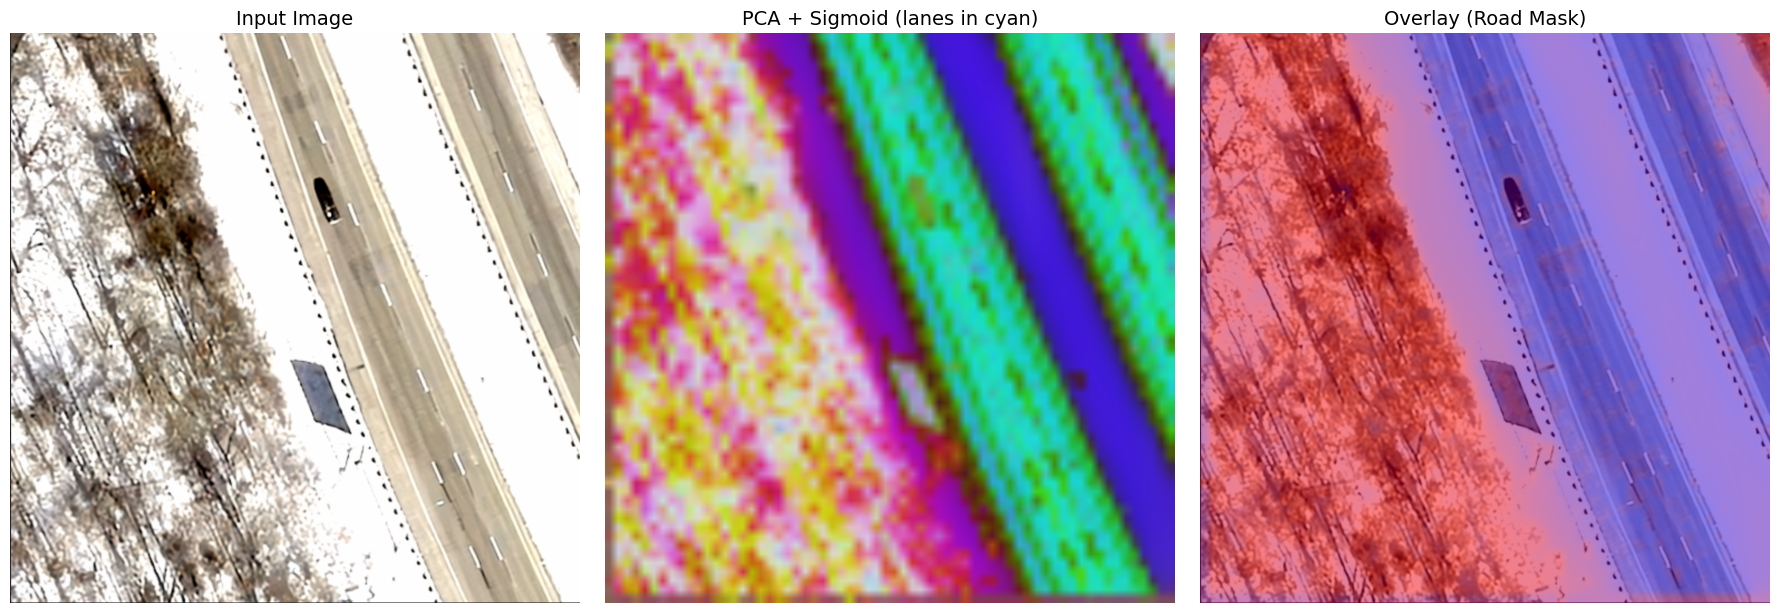

Saved visualization to: lane_features_visualization.png


In [11]:

# ============ Run Visualization ============
if __name__ == "__main__":
    # Test with the provided image URL
    # image_url = "https://www.shutterstock.com/shutterstock/videos/3502420789/thumb/1.jpg"
    # image_url = "/content/Extension_Lines_at_Intersections.jpg"
    # image_url = "/content/Screenshot 2026-02-09 at 12.48.23 PM.png"
    # image_url = "/content/drive/MyDrive/Colab Notebooks/test_data/1_normal_scene.png"
    # image_url = "/content/drive/MyDrive/Colab Notebooks/test_data/2_lidar_gap.png"
    # image_url = "/content/drive/MyDrive/Colab Notebooks/test_data/3_dense_scene.png"
    # image_url = "/content/drive/MyDrive/Colab Notebooks/test_data/1_normal_scene_crop.png"
    image_url = "/content/drive/MyDrive/Colab Notebooks/test_data/road_2.png"

    # Lane-optimized visualization
    print("\n" + "="*50)
    print("Running lane-optimized visualization...")
    print("="*50 + "\n")

    lane_results = visualize_lane_features(
        image_url,
        image_size=1024,
        save_path="lane_features_visualization.png"
    )
